# Actor-Critic
### Policy-based RL
- 업데이트의 대상이 정책
- Table형태의 정책 X -> function형태의 정책
- approximate된 정책의 input은 상태벡터, output은 각 행동을 할 확률
    - Discrete한 액션은 행동을 할 확률
    - Continous한 액션은 확률분포
- 확률적으로 행동을 선택(stochastic policy)
- 목적함수 $J(\theta)$ (=performance measure) : 정책에 대한 평가기준이 됨. 
    - 목적함수를 최대로 하는 정책을 습득하는 것
    - $J(\theta)$ : 에피소드 동안 받을 것이라고 기대하는 보상의 합
    
### Actor-Critic
- 스텝마다 업데이트를 수행
- 반환값의 수식이 아래와 같이 변경됨
    
$$G_t \rightarrow R_t + \gamma V_v (S_{t+1})$$
    
    
### Actor
- 정책을 근사 : $\theta$
- Adventage function(Bootstraping) -> Online

$$\nabla_{\theta}J(\theta) \sim \nabla_{\theta} log \pi_{\theta} (A_t|S_t) (R_t + \gamma V_{v}(S_{t+1}) - V_v (S_t))$$
    
### Critic
- 가치함수를 근사 : $v$

$$\nabla_{v}(r + \gamma V_v(s') - V_v(s))^2$$

### 1. Import Libs

In [1]:
import datetime
import os
import gym
import numpy as np
from keras.layers import Dense, Input
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras.backend as K
import matplotlib.pyplot as plt

EPISODES = 300
plt.style.use('ggplot')

Using TensorFlow backend.


### 2. Define Agent & Model

In [2]:
class A2CAgent:
    def __init__(self, state_size, action_size):
        self.render = False
        self.load_model = False
        
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1
        
        self.discount_factor = 0.999
        # actor가 빨리 수렴하는 경향이 있기 때문에 lr를 critic의 lr보다 작게 설정
        self.actor_lr = 0.001
        self.critic_lr = 0.003
        
        self.actor, self.critic = self.build_model()
        
        self.actor_updator = self.actor_optimizer()
        self.critic_updator = self.critic_optimizer()
        
        if self.load_model:
            self.actor.load_weights("./save_model/cartpole_actor_2.h5")
            self.critic.load_weights('./save_model/cartpole_critic_2.h5')
            
    def build_model(self):
        
        state_input = Input(shape=[self.state_size])
        fc0 = Dense(24, activation='relu', kernel_initializer='he_uniform')(state_input)
        fc1 = Dense(24, activation='relu', kernel_initializer='he_uniform')(fc0)
        
        policy = Dense(self.action_size, activation='softmax', kernel_initializer='he_uniform')(fc0)
        value = Dense(self.value_size, activation='linear', kernel_initializer='he_uniform')(fc1)
        
        actor = Model(inputs=state_input, outputs=policy)
        critic = Model(inputs=state_input, outputs=value)
        
        actor._make_predict_function()
        critic._make_predict_function()
        
        actor.summary()
        critic.summary()
        
        return actor, critic
    
    def get_action(self, state):
        policy = self.actor.predict(state, batch_size = 1).flatten()
        return np.random.choice(self.action_size, 1, p=policy)[0]
    
    # 정책신경망을 업데이트하는 함수
    def actor_optimizer(self):
        action = K.placeholder(shape=[None, self.action_size])
        advantage = K.placeholder(shape=[None, ])

        action_prob = K.sum(action * self.actor.output, axis=1)
        cross_entropy = K.log(action_prob) * advantage
        loss = -K.sum(cross_entropy)

        optimizer = Adam(lr=self.actor_lr)
        updates = optimizer.get_updates(self.actor.trainable_weights, [], loss)
        train = K.function([self.actor.input, action, advantage], [],
                           updates=updates)
        return train

    # 가치신경망을 업데이트하는 함수
    def critic_optimizer(self):
        target = K.placeholder(shape=[None, ])

        loss = K.mean(K.square(target - self.critic.output))

        optimizer = Adam(lr=self.critic_lr)
        updates = optimizer.get_updates(self.critic.trainable_weights, [], loss)
        train = K.function([self.critic.input, target], [], updates=updates)

        return train
    
    
    def train_model(self, state, action, reward, next_state, done):
        value = self.critic.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]
        
        act = np.zeros([1, self.action_size])
        act[0][action] = 1
        
        # 벨만 기대 방정식을 이용한 어드벤티지, 업데이트 타깃
        if done:
            advantage = reward - value
            target = [reward]
        else:
            advantage = (reward + self.discount_factor * next_value) - value
            target = reward + self.discount_factor * next_value
        
        # train = K.function([self.actor.input, action, advantage], [], updates=updates)
        self.actor_updator([state, act, advantage])
        # train = K.function([self.critic.input, target], [], updates=updates)
        self.critic_updator([state, target])

### 3. Train

[2018-05-11 20:22:42,184] Making new env: CartPole-v1


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 50        
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_2 (Den

episode :  203     score  : 60.0
episode :  204     score  : 77.0
episode :  205     score  : 67.0
episode :  206     score  : 36.0
episode :  207     score  : 92.0
episode :  208     score  : 54.0
episode :  209     score  : 34.0
episode :  210     score  : 55.0
episode :  211     score  : 60.0
episode :  212     score  : 78.0
episode :  213     score  : 107.0
episode :  214     score  : 299.0
episode :  215     score  : 177.0
episode :  216     score  : 180.0
episode :  217     score  : 210.0
episode :  218     score  : 18.0
episode :  219     score  : 27.0
episode :  220     score  : 25.0
episode :  221     score  : 42.0
episode :  222     score  : 107.0
episode :  223     score  : 289.0
episode :  224     score  : 89.0
episode :  225     score  : 88.0
episode :  226     score  : 199.0
episode :  227     score  : 188.0
episode :  228     score  : 252.0
episode :  229     score  : 369.0
episode :  230     score  : 374.0
episode :  231     score  : 358.0
episode :  232     score  : 36

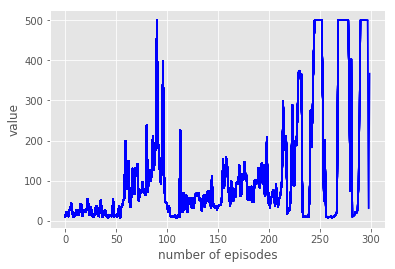

In [3]:
start = datetime.datetime.now()

graph_path = os.path.join(os.getcwd(), 'save_graph')
model_path = os.path.join(os.getcwd(), 'save_model')

if not os.path.isdir(graph_path):
    os.mkdir(graph_path)
if not os.path.isdir(model_path):
    os.mkdir(model_path)

env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = A2CAgent(state_size, action_size)

scores, episodes = [], []

for episode in range(EPISODES):
    score = 0
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    
    # step별로 수행
    while True:
        if agent.render:
            env.render()

        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        
        reward = reward if not done or score == 499 else -100
        
        # 모델을 step마다 학습
        agent.train_model(state, action, reward, next_state, done)
        
        score += reward
        state = next_state
        
        # 에피소드가 끝나면
        if done:
            score = score if score == 500 else score + 100
            scores.append(score)
            episodes.append(episode)
            plt.plot(episodes, scores, 'b')
            plt.ylabel("value")
            plt.xlabel("number of episodes")
            plt.savefig('./save_graph/cartpole_A2C.png')
            print("episode : ", episode, "    score  :", score)
            
            if np.mean(scores[-min(10, len(scores)):]) > 490:
                # sys.exit()
                agent.actor.save_weights("./save_model/cartpole_actor_2.h5")
                agent.critic.save_weights("./save_model/cartpole_critic_2.h5")
            break
            
    if episode % 50 == 0:
        agent.actor.save_weights("./save_model/cartpole_actor_2.h5")
        agent.critic.save_weights("./save_model/cartpole_critic_2.h5")
        
env.close()
end = datetime.datetime.now()
elapsed = end - start
print(elapsed)

- 2분 24초